In [1]:
import sqlite3
import pandas as pd
import numpy as np
from pvops.text.preprocess import text_remove_numbers_stopwords

Read in O&M data

In [2]:
PATH_TO_PVROM = '../../../pvrom-dtb/PVROM/PVROM.db'
con = sqlite3.connect(PATH_TO_PVROM)
cur = con.cursor() #instantiate a cursor obj
cur.execute("SELECT name FROM sqlite_master WHERE type='table';") # get all tables in dtb
OM_df = pd.read_sql_query("SELECT * FROM OM", con)

#### Initial exploration

Look at data: how many tickets identify an asset? How many don't?

In [3]:
asset_is_null_mask = OM_df['Asset'].isnull()
desc_is_null_mask = OM_df['GeneralDesc'].isnull()
print(f'{asset_is_null_mask.sum()} / {len(OM_df)} are null ({asset_is_null_mask.mean().round(3) * 100}%)')

4688 / 52838 are null (8.9%)


In [4]:
# make new dataframe with info we want
simple_asset_df = OM_df.loc[~np.bitwise_or(asset_is_null_mask, desc_is_null_mask), ['GeneralDesc','Asset']]

# use asset mapping to simplify
simple_asset_df['Asset'] = simple_asset_df['Asset'].str.lower()

# boolean to describe if it's an inverter asset
simple_asset_df['IsInverter'] = simple_asset_df['Asset'].str.contains('inverter')
simple_asset_df = simple_asset_df.drop(columns=['Asset'])

# 
simple_asset_df['DescContainsInverter'] = simple_asset_df['GeneralDesc'].str.lower().str.contains('inverter')

In [5]:
true_inverters = simple_asset_df[simple_asset_df['IsInverter']]
pred_inverters = true_inverters[true_inverters['DescContainsInverter']]

print('%d datapoints are truly inverters' % len(true_inverters))
print('%d of those datapoints were predicted correctly (%.1f%%).' % (len(pred_inverters),
                                                                     len(pred_inverters) / len(true_inverters) * 100))

true_not_inverters = simple_asset_df[~simple_asset_df['IsInverter']]
pred_not_inverters = true_not_inverters[~true_not_inverters['DescContainsInverter']]
print('%d datapoints are truly not inverters' % len(true_not_inverters))
print('%d of those datapoints were predicted correctly (%.1f%%).' % (len(pred_not_inverters),
                                                                     len(pred_not_inverters) / len(true_not_inverters) * 100))

print('Overall accuracy: %.1f%%' % ((len(pred_inverters) + len(pred_not_inverters)) / len(simple_asset_df) * 100))

15430 datapoints are truly inverters
14333 of those datapoints were predicted correctly (92.9%).
32691 datapoints are truly not inverters
27994 of those datapoints were predicted correctly (85.6%).
Overall accuracy: 88.0%


A "good" machine learning model would need to perform better than this naive approach (better than 88%).

#### Reproducing SVM method from paper

Clean the data

In [6]:
from nltk import corpus
from nltk.stem import WordNetLemmatizer

from nltk import download
download('wordnet')
download('punkt_tab')

stopwords = corpus.stopwords.words('english')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\agmoore\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\agmoore\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [7]:
# keep only the rows where the asset and general description is listed
OM_nonnull = OM_df.dropna(subset=['Asset','GeneralDesc']).copy()
all_descr = OM_df.dropna(subset='GeneralDesc')['GeneralDesc'].str.lower().astype('str')

# clean the asset label, make it lowercase
OM_nonnull['AssetCleaned'] = OM_nonnull.apply(lambda x: text_remove_numbers_stopwords(x['Asset'], stopwords), axis='columns')
OM_nonnull['AssetCleaned'] = OM_nonnull['AssetCleaned'].str.lower()

# get the event description to be lowercase
OM_nonnull['GeneralDescLower'] = OM_nonnull['GeneralDesc'].str.lower()

In [8]:
x = OM_nonnull['GeneralDescLower'].copy()
y = OM_nonnull['AssetCleaned'].copy()

SVM

In [98]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, make_scorer

from scipy.sparse import vstack

import matplotlib.pyplot as plt

In [28]:
#train/test splits
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=24)

#Transform text data into numerical values
tf_idf_vectorizer = TfidfVectorizer(min_df=1, stop_words=stopwords, ngram_range=(1,2), sublinear_tf=True)

# alldata = pd.Series(OM_nonnull["GeneralDescLower"].astype(str))

#fit cv to all data so that all vocab is represented
tf_idf_vectorizer.fit(all_descr)

x_train_vectorized = tf_idf_vectorizer.transform(x_train) #transform the training set
x_test_vectorized = tf_idf_vectorizer.transform(x_test) #transform the testing set

Try out various models:

In [11]:
verbose = False
dataset_sizes = [10, 30, 100, 300, 1000, 3000]#, 10000, len(y_train)]
model_types = [MultinomialNB, LinearSVC, LogisticRegression]

models_summary = {}
for dataset_size in dataset_sizes:
    print('Using dataset of size', dataset_size) if verbose else None
    indices = np.random.choice(np.arange(len(y_train)), size=dataset_size, replace=False)
    np.random.shuffle(indices)

    x_train_subset = vstack([x_train_vectorized.getrow(idx) for idx in indices])
    y_train_subset = y_train[y_train.index[indices]]

    models_summary[dataset_size] = {}

    for model_type in model_types:
        model = model_type()
        model_name = model.__class__.__name__
        print('Training', model_name) if verbose else None

        model.fit(x_train_subset, y_train_subset)
        # train_score = model.score(x_train_subset, y_train_subset)
        test_score = model.score(x_test_vectorized, y_test)
        print('Test Accuracy: %.3f' % test_score) if verbose else None

        model_dict = {'model' : model,
                    # 'train score' : train_score,
                    'test score' : test_score}
        models_summary[dataset_size][model_name] = model_dict
    
    print() if verbose else None

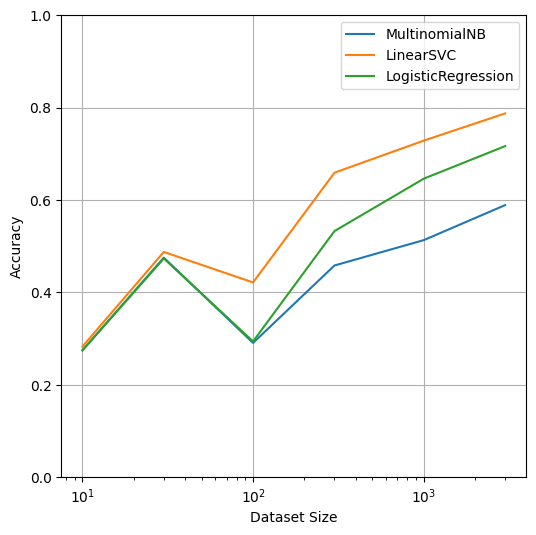

In [12]:
fig, ax = plt.subplots(figsize=(6,6))

for model_name in models_summary[dataset_sizes[0]].keys():
    scores = [models_summary[dataset_size][model_name]['test score'] for dataset_size in models_summary.keys()]
    ax.plot(dataset_sizes, scores, label=model_name)
    ax.set_xlabel('Dataset Size')
    ax.set_ylabel('Accuracy')
    ax.set_xscale('log')
    ax.set_ylim([0,1])
ax.legend()
ax.grid();

Look more into: was the final accuracy figure on these 50-ish classes? Or on some simplified version? If all we're trying to do is identify inverter-related records, could probably simplify this a lot. -> i.e. just a binary classification problem (whether record is about inverters or not)

There was a stat in the paper: 33% of records are inverter-related. I'm guessing this accounts for multiple classes?

#### Same thing, but binary classification

In [13]:
y_train_binary = y_train.str.contains('inv').astype(int)
y_test_binary = y_test.str.contains('inv').astype(int)

In [14]:
verbose = False
dataset_sizes = [10, 30, 100, 300, 1000, 3000, 10000, len(y_train)]
model_types = [MultinomialNB, LinearSVC, LogisticRegression]

binary_models_summary = {}
for dataset_size in dataset_sizes:
    print('Using dataset of size', dataset_size) if verbose else None
    indices = np.random.choice(np.arange(len(y_train)), size=dataset_size, replace=False)
    np.random.shuffle(indices)

    x_train_subset = vstack([x_train_vectorized.getrow(idx) for idx in indices])
    y_train_binary_subset = y_train_binary[y_train_binary.index[indices]]

    binary_models_summary[dataset_size] = {}

    for model_type in model_types:
        model = model_type()
        model_name = model.__class__.__name__
        print('Training', model_name) if verbose else None

        model.fit(x_train_subset, y_train_binary_subset)
        # train_score = model.score(x_train_subset, y_train_subset)
        test_score = model.score(x_test_vectorized, y_test_binary)
        print('Test Accuracy: %.3f' % test_score) if verbose else None

        model_dict = {'model' : model,
                    # 'train score' : train_score,
                    'test score' : test_score}
        binary_models_summary[dataset_size][model_name] = model_dict
    
    print() if verbose else None

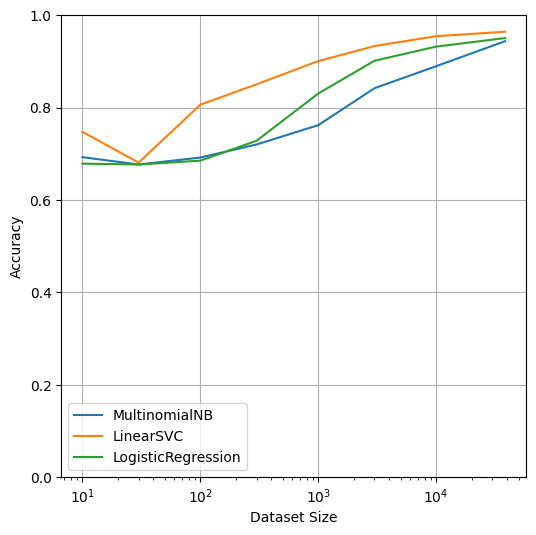

In [15]:
fig, ax = plt.subplots(figsize=(6,6))

for model_name in binary_models_summary[dataset_sizes[0]].keys():
    scores = [binary_models_summary[dataset_size][model_name]['test score'] for dataset_size in binary_models_summary.keys()]
    ax.plot(dataset_sizes, scores, label=model_name)
    ax.set_xlabel('Dataset Size')
    ax.set_ylabel('Accuracy')
    ax.set_xscale('log')
    ax.set_ylim([0,1])
ax.legend()
ax.grid();

In [16]:
binary_models_summary[38496]

{'MultinomialNB': {'model': MultinomialNB(), 'test score': 0.9435844155844156},
 'LinearSVC': {'model': LinearSVC(), 'test score': 0.964051948051948},
 'LogisticRegression': {'model': LogisticRegression(),
  'test score': 0.9503376623376624}}

In [17]:
(y_train_binary.sum() + y_test_binary.sum()) / len(y)

0.32065002805427983

So we do see that 32% of records are inverter-related.

Furthermore, we get a much better accuracy with all three models using a binary response. The model also trains much faster. I have a feeling this is what was ultimately done in the paper, even though I don't see the code for it. The accuracy is much closer, and the short runtime also more accurately reflects what they reported. Finally, LinearSVC seems to perform consistently the best (although this is without any hyperparameter tuning)

#### For now, let's go forward with LinearSVC

In [116]:
import sys
sys.path.append('../text')
import defaults, classify
from sklearn.model_selection import GridSearchCV

In [120]:
param_grid = defaults.supervised_classifier_defs('detailed')[0]['LinearSVC']
param_grid = {param.split('__')[-1]: vals for  param, vals in param_grid.items()}
param_grid = {'C':param_grid['C']} # experimentation showed max_iter didn't do much
gridsearch = GridSearchCV(LinearSVC(), param_grid, n_jobs=-1)
gridsearch.fit(full_x_vectorized, full_y_binary)

GridSearchCV(estimator=LinearSVC(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10.0, 100.0, 1000.0]})

In [122]:
for params, mean_test_score, std_test_score, time in zip(gridsearch.cv_results_['params'],
                                                            gridsearch.cv_results_['mean_test_score'],
                                                            gridsearch.cv_results_['std_test_score'],
                                                            gridsearch.cv_results_['mean_fit_time']):
    print('Params: %s:\t %.3f+-%.3f (took %.1f seconds to fit)'%(params, mean_test_score, std_test_score, time))

Params: {'C': 0.01}:	 0.880+-0.042 (took 2.5 seconds to fit)
Params: {'C': 0.1}:	 0.904+-0.055 (took 1.6 seconds to fit)
Params: {'C': 1}:	 0.901+-0.055 (took 3.4 seconds to fit)
Params: {'C': 10.0}:	 0.890+-0.053 (took 24.8 seconds to fit)
Params: {'C': 100.0}:	 0.881+-0.050 (took 50.2 seconds to fit)
Params: {'C': 1000.0}:	 0.879+-0.050 (took 48.9 seconds to fit)


After all that, the best parameter choice is `C=1`... the default (and what we were already using). Oh well, good to be thorough.

#### Label datapoints with asset missing

In [23]:
full_x_vectorized = tf_idf_vectorizer.transform(x)
full_y_binary = y.str.contains('inv').astype(int)
final_model = LinearSVC().fit(full_x_vectorized, full_y_binary)

x_to_predict = OM_df[asset_is_null_mask & ~desc_is_null_mask]['GeneralDesc']
x_to_predict_vectorized = tf_idf_vectorizer.transform(x_to_predict)
asset_gap_fills = final_model.predict(x_to_predict_vectorized)

Now, let's gapfill everything, and then save the inverter records

In [24]:
OM_gapfilled_df = OM_df.copy()
OM_gapfilled_df['AssetIsInverter'] = OM_gapfilled_df['Asset'].str.lower().str.contains('inv')
OM_gapfilled_df.loc[asset_is_null_mask,'AssetIsInverter'] = asset_gap_fills.astype(bool)
OM_inverter_df = OM_gapfilled_df[OM_gapfilled_df['AssetIsInverter']].drop(columns=['AssetIsInverter'])

Let's also grab the relevant metadata and add to our dataframe

In [25]:
meta_df = pd.read_sql_query("SELECT * FROM METADATA", con)[['randid','states','Commissioning_Date']]
final_df = OM_inverter_df.merge(meta_df, on='randid', how='left')

In [26]:
final_df.to_csv('inverter_OM_records.csv', index=False)

#### Redo last part, but using pvops functions

In [124]:
pipeline_steps = [('tfidf', tf_idf_vectorizer),
                  ('clf', None)]

classifiers = {'LinearSVC' : LinearSVC(),
               'LogisticRegression' : LogisticRegression(),
               'RandomForestClassifier' : RandomForestClassifier(),
               'MultinomialNB' : MultinomialNB()}

param_grid = {'LinearSVC' : {'clf__C': [0.01, 0.1, 1, 10, 100]},
              'LogisticRegression' : {'clf__C' : [0.01, 0.1, 1, 10, 100]},
              'RandomForestClassifier' : {'clf__n_estimators': [4, 16, 64],
                                          'clf__criterion': ['gini', 'entropy'],
                                          'clf__max_depth': [1, 2, 4]},
              'MultinomialNB' : {'clf__alpha' : [0.01, 0.1, 1, 10, 100]}}

results = classify.classification_deployer(x, full_y_binary.astype(bool),
                                            n_splits=5,
                                            classifiers=classifiers,
                                            search_space=param_grid,
                                            pipeline_steps=pipeline_steps,
                                            scoring=make_scorer(accuracy_score),
                                            verbose=10)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Better score (0.905) found on classifier: LinearSVC
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [131]:
x_to_predict = OM_df[asset_is_null_mask & ~desc_is_null_mask]['GeneralDesc']
asset_gap_fills = results[1].predict(x_to_predict)

In [137]:
OM_gapfilled_df = OM_df.copy()
OM_gapfilled_df['AssetIsInverter'] = OM_gapfilled_df['Asset'].str.lower().str.contains('inv')
OM_gapfilled_df.loc[asset_is_null_mask,'AssetIsInverter'] = asset_gap_fills
OM_inverter_df = OM_gapfilled_df[OM_gapfilled_df['AssetIsInverter']].drop(columns=['AssetIsInverter'])

Let's also grab the relevant metadata and add to our dataframe

In [139]:
meta_df = pd.read_sql_query("SELECT * FROM METADATA", con)[['randid','states','Commissioning_Date']]
final_df = OM_inverter_df.merge(meta_df, on='randid', how='left')

In [140]:
final_df.to_csv('inverter_OM_records.csv', index=False)